In [14]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

pd.set_option('float_format', '{:6.4f}'.format)
sns.set(style='ticks')

import warnings
warnings.filterwarnings("ignore")

In [8]:
df=pd.read_csv("expend.csv")

In [9]:
#2
df[['tot3','f3']].describe()

,tot3,f3
count,427.0000,427.0000
mean,35762.8059,6890.8819
std,18053.3135,2745.7483
min,8728.8603,883.9856
25%,23189.4650,4946.0914
50%,31847.1185,6838.4314
75%,44050.5167,8788.3583
max,124564.1872,17270.7470


In [10]:
#3
df['log_tot3']=df['tot3'].map(lambda x: np.log(x))
df['log_f3']=df['f3'].map(lambda x: np.log(x))

In [11]:
df[['tot3','f3','log_tot3','log_f3']].describe()

,tot3,f3,log_tot3,log_f3
count,427.0000,427.0000,427.0000,427.0000
mean,35762.8059,6890.8819,10.3689,8.7413
std,18053.3135,2745.7483,0.4838,0.4759
min,8728.8603,883.9856,9.0744,6.7844
25%,23189.4650,4946.0914,10.0515,8.5063
50%,31847.1185,6838.4314,10.3687,8.8303
75%,44050.5167,8788.3583,10.6931,9.0812
max,124564.1872,17270.7470,11.7326,9.7568


In [18]:
#4
model = OLS(df.log_f3, sm.add_constant(df.log_tot3))
results = model.fit(cov_type='HC0') 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_f3   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     163.3
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           7.16e-32
Time:                        14:02:11   Log-Likelihood:                -208.53
No. Observations:                 427   AIC:                             421.1
Df Residuals:                     425   BIC:                             429.2
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0466      0.449      6.781      0.0

In [20]:
results.conf_int(alpha=0.05)

,0,1
const,2.1661,3.9271
log_tot3,0.4650,0.6334


двухсторонний 95% доверительный интервал для log_tot3 (0.46;0.63)

#5
Вероятно, расход на питание будет связан с количеством детей, например, тем у кого много детей естественно родители будут тратить больше денег на питание когда у них 5 детей например, по сравнению если у них нет детей во все, из-за этого возникает связь с другими факторами, поэтому это условно пропущенная переменная и будет возникать смещение коэффицентов.
У нас в примере постоянная эластичность B1=E, следовательно если существует взаимосвязь от детей, значит коэффициенты смещены, скорее всего коэффициент перед количеством детей будет значимым и положительным, поэтому коэф перед доходом должен быть меньше, так как дополнительную величину мы будет получать от другого фактора.

In [32]:
#6 
model = OLS(df.log_f3, sm.add_constant(df[['log_tot3','nahm','nch06','nch711']]))
results = model.fit(cov_type='HC0') 
results.conf_int(alpha=0.05)

,0,1
const,3.6968,5.2939
log_tot3,0.2788,0.4402
nahm,0.1610,0.2502
nch06,0.0959,0.1830
nch711,0.0808,0.1553


коэффицент B1 упал по сравнению с предыдущим пунктом, что говорит о смещении, значит существует зависимость от количества детей

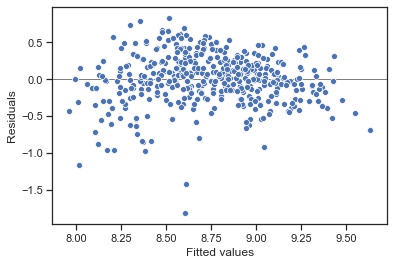

In [35]:
def ResidualVsFittedPlot(Y, X, data, **kwarg):
    x = sm.add_constant(data[X])
    y = data[Y]
    lm = OLS(y, x)
    res = lm.fit()
    fit = res.fittedvalues
    resid = res.resid
    sns.scatterplot(fit, resid, **kwarg)
    plt.axhline(0, color='black', linewidth=0.5, zorder=0)
    plt.ylabel("Residuals")
    plt.xlabel("Fitted values")
    
ResidualVsFittedPlot('log_f3',['log_tot3','nahm','nch06','nch711'],df)

нет особых заметных паттернов поведения зависимости y от U, так как все достаточно кучно лежат и нет больших выбросов => нет проблемы с функциональной формой

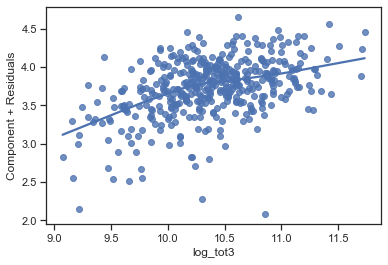

In [41]:
def ComponentPlusResidualPlot(Y, X, x, data, **kwarg):
    x1 = sm.add_constant(data[X])
    y = data[Y]
    j = X.index(x) + 1
    lm = OLS(y, x1)
    res = lm.fit()
    beta = res.params[j]
    fit = beta*data[x] + res.resid
    sns.regplot(data[x], fit, lowess=True, **kwarg)
    plt.ylabel("Component + Residuals")

ComponentPlusResidualPlot('log_f3',['log_tot3','nahm','nch06','nch711'],'log_tot3',df)

наклон B1, есть небольшие выбросы снизу

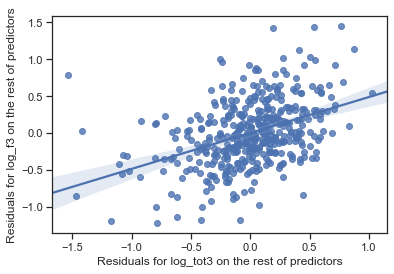

In [38]:
def AddedVariablePlot(Y, X, x, data, **kwarg):
    X0 = X.copy()
    X0.remove(x)
    x0 = sm.add_constant(data[X0])
    x1 = data[x]
    y = data[Y]
    lm1 = OLS(y, x0)
    res1 = lm1.fit()
    fit1 = res1.fittedvalues
    resid1 = res1.resid
    lm2 = OLS(x1, x0)
    res2 = lm2.fit()
    fit2 = res2.fittedvalues
    resid2 = res2.resid
    sns.regplot(resid1, resid2, **kwarg)
    plt.xlabel("Residuals for %s on the rest of predictors" % x)
    plt.ylabel("Residuals for %s on the rest of predictors" % Y)
    
AddedVariablePlot('log_f3',['log_tot3','nahm','nch06','nch711'],'log_tot3',df)

парная регрессия log f3 на log tot3 при условии, что остальные факторы константы, точки относительно далеко от (0,0) выбросы

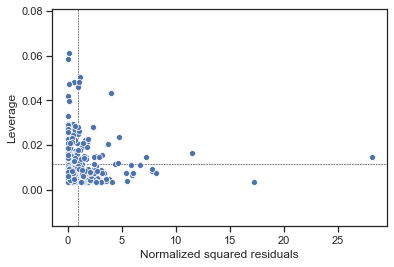

In [40]:
def LeverageVsSquaredResidualsPlot(Y, X, data, **kwarg):
    x1 = sm.add_constant(data[X])
    y = data[Y]
    lm = OLS(y, x1)
    res = lm.fit()
    resid2 = res.resid_pearson**2
    # TODO: work with missing values
    leverage = np.diag(np.dot(x1.dot(np.linalg.inv(x1.T.dot(x1))), x1.T))
    sns.scatterplot(resid2, leverage, **kwarg)
    plt.axhline(np.mean(leverage), color='black', linewidth=0.5, linestyle="--", zorder=0)
    plt.axvline(np.mean(resid2), color='black', linewidth=0.5, linestyle="--", zorder=0)
    plt.xlabel("Normalized squared residuals")
    plt.ylabel("Leverage")

LeverageVsSquaredResidualsPlot('log_f3',['log_tot3','nahm','nch06','nch711'],df)

точки, которые находятся в пределах, линий, нормальные, справа вверху, например (5;0.04) выброс

In [42]:
#7
model = OLS(df.log_f3, sm.add_constant(df[['log_tot3','nahm','nch06','nch711']]))
results = model.fit(cov_type='HC0') 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_f3   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     89.66
Date:                Fri, 06 Dec 2019   Prob (F-statistic):           4.23e-55
Time:                        01:02:35   Log-Likelihood:                -146.69
No. Observations:                 427   AIC:                             303.4
Df Residuals:                     422   BIC:                             323.7
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4954      0.407     11.034      0.0

#7
все коэффициенты значимы, если брать в расчет коэффициенты adj. R-square, AIC, Bic то эти коэффиценты стали лучше с добавленными факторами.
интерпретация коэффициентов 
1. при увеличении полные рассходы в гюльденах на 1%, расходы в гюльденах на питание одной семьи возрастают на 0,3595%
2. при увеличении количество детей старше 11 лет на 1%, расходы в гюльденах на питание одной семьи возрастают на 0.002056%
3. при увеличении количество детей младше 6 лет на 1%, расходы в гюльденах на питание одной семьи возрастают на 0.001395%
4. при увеличении количество детей от 7 до 11 на 1%,расходы в гюльденах на питание одной семьи возрастают на 0.001180%

#8
Предположим что нет никакого отличия, значит H0: B3=B4, если есть отличия, тогда B3!=B4
на 5% уровне значимости гипотеза Н0 отвергается в пользу Н1, следовательно есть отличия

In [43]:
print(results.t_test([0,0,0,1,-1]))

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0215      0.028      0.760      0.447      -0.034       0.077


In [44]:
#9
df['log_tot3s']=df['log_tot3'].map(lambda x: x**2)
model = OLS(df.log_f3, sm.add_constant(df[['log_tot3','nahm','nch06','nch711','log_tot3s']]))
results = model.fit(cov_type='HC0') 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_f3   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     77.27
Date:                Fri, 06 Dec 2019   Prob (F-statistic):           2.29e-57
Time:                        02:37:05   Log-Likelihood:                -141.89
No. Observations:                 427   AIC:                             295.8
Df Residuals:                     421   BIC:                             320.1
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.6135      6.057     -2.083      0.0

на 5% уровне значимости переменная лог тот3с является значимой, при этом вылезает ошибка о том, что есть сильная мультиколинеарность или какая-то другая проблема